# Brain Tumor Detection using Tensorflow CNN with and without data augmentation/ EfficientNet-B0

<div style="text-align: center;">
    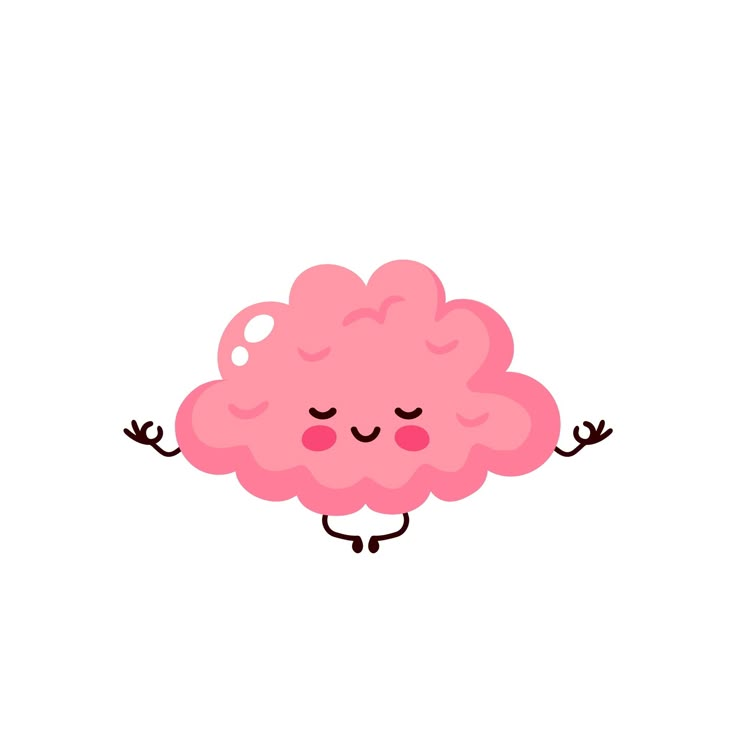
    <p><strong>In this notebook I'll tackle one of the most important medical tasks related to computer vision: brain tumour detection and classification, using Tensorflow Convolutional Neural networks (CNN) with and without data augmentation, and more powerful architectures EfficientNet-B0, Res-Net-101</strong></p>
</div>

## Importing Libraries

In [3]:
import os
import kagglehub
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

In [4]:
from tensorflow.keras.applications import EfficientNetB0, ResNet101 

In [27]:
import visualkeras
from tensorflow.keras.utils import plot_model

## Data Loading

In [6]:
# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

In [7]:
path

'C:\\Users\\Alex\\.cache\\kagglehub\\datasets\\sartajbhuvaji\\brain-tumor-classification-mri\\versions\\2'

In [8]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

image_size = 256
for i in labels:
  folderPath = os.path.join(f'{path}/Training', i)
  for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
  folderPath = os.path.join(f'{path}/Testing', i)
  for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 235.24it/s]


In [9]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [10]:
y_train

array(['glioma_tumor', 'glioma_tumor', 'glioma_tumor', ...,
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor'],
      dtype='<U16')

## Visualizatioin

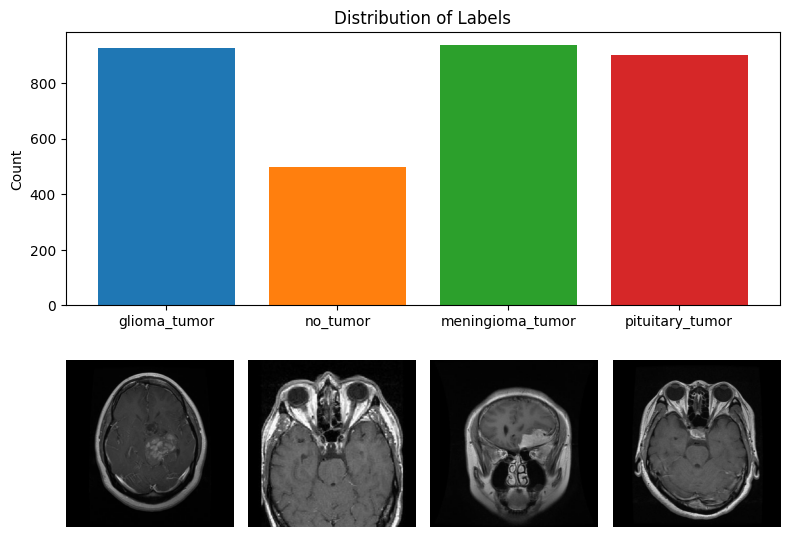

In [11]:
label_counts = {label: np.sum(y_train == label) for label in labels}

plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)

# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

## Content Description
1. Glioma: Cancerous brain tumors in glial cells.
2. Meningioma: Non-cancerous tumors originating from the meninges.
3. No Tumor: Normal brain scans without detectable tumors.
4. Pituitary: Tumors affecting the pituitary gland, which can be cancerous or non-cancerous.

## Data augmentation

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20, # Rotate images by ±20 degrees
    width_shift_range=0.1, # Shift width by 10% of original size
    height_shift_range=0.1, # Shift height by 10% of the original size
    zoom_range=0.1, # Zoom in/out by 10%
    horizontal_flip=False, # Horizontal reflection prohibited
    vertical_flip=False,  # Vertical reflection is prohibited
    fill_mode='nearest') # Fill empty pixels with nearest values

datagen.fit(X_train)

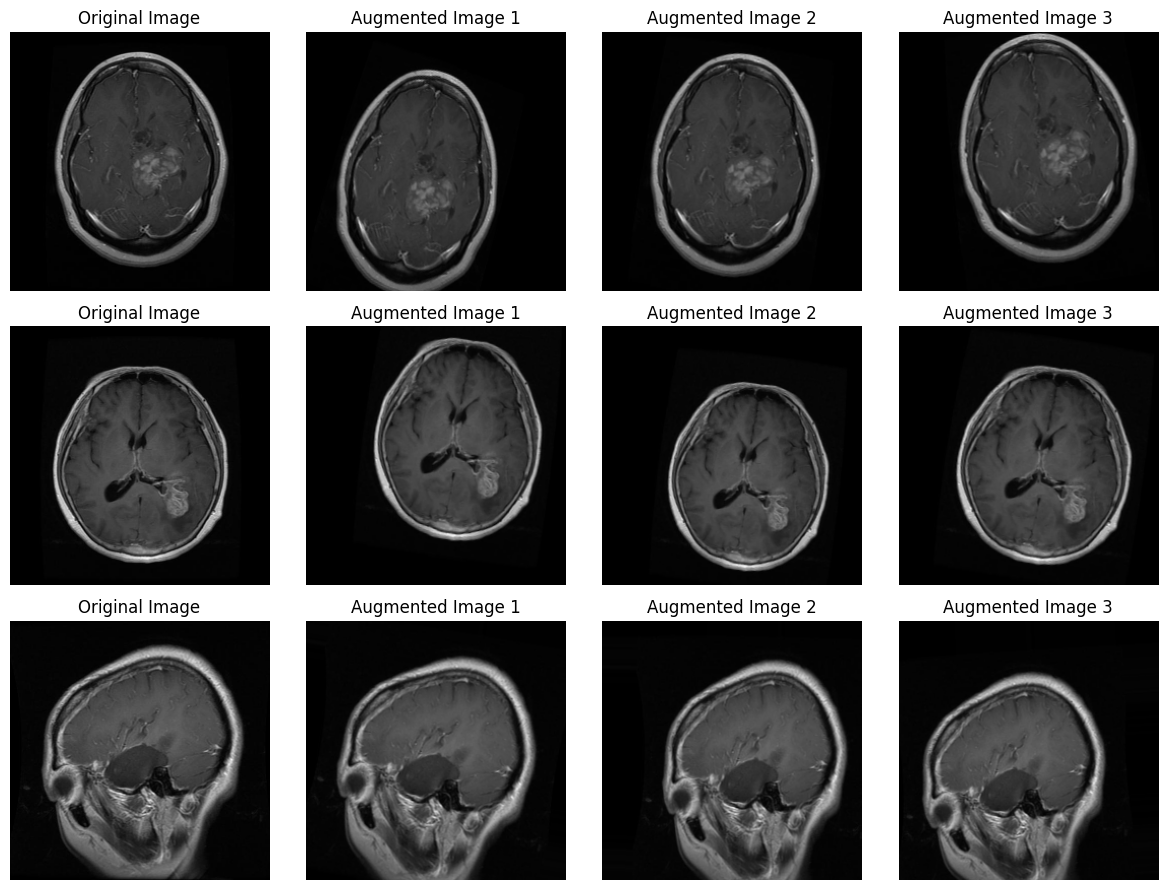

In [13]:
def visualize_augmented_images(image_generator, num_samples, num_augmented_images):
    augmented_images = []
    for sample in X_train[:num_samples]:

        # Create a list to store augmented versions of a sample
        augmented_samples = [sample]
        for _ in range(num_augmented_images):
            augmented_samples.append(image_generator.random_transform(sample))
        augmented_images.append(augmented_samples)

    # Plot original and augmented images
    fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=( 12, num_samples * 3))
    for i, sample in enumerate(augmented_images):
        for j, image in enumerate(sample):
            axes[i,j].imshow(image)
            if j == 0:
                axes[i, j].set_title('Original Image')
            else:
                axes[i,j].set_title(f'Augmented Image {j}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

#Visualize augmented images to see how it works
visualize_augmented_images(datagen, num_samples=3, num_augmented_images=3)

## Data Preparation

In [14]:
# Convert y_train labels to one-hot encoded format using pandas
y_train = np.array(pd.get_dummies(y_train))

In [15]:
#Split the dataset into training, testing and validation sets
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(X_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'X_valid shape: {(X_valid).shape}\n'
      f'y_validshape: {(y_valid).shape}')

X_train shape: (2643, 256, 256, 3)
y_train shape: (2643, 4)
X_test shape: (327, 256, 256, 3)
y_test shape: (327, 4)
X_valid shape: (294, 256, 256, 3)
y_validshape: (294, 4)


## Normalization

In [16]:
# Normalize pixel values of training images to the range [0,1]
X_train_norm = X_train / 255
X_test_norm = X_test / 255
X_valid_norm = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train_norm.max()} - {X_train_norm.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


In [17]:
input_shape = (256, 256, 3)

## Model with Data Augmentation

In [23]:
# Define the model
model_with_aug = Sequential(
    [
        Input(input_shape),
        Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.3),
        
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')  # the Softmax function works for multiclass classification problems
                                            # and the Sigmoid function is a better option for binary-class problems.
    ]
)

In [24]:
model_with_aug.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_with_aug.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,128,564 (8.12 MB)

 Trainable params: 2,128,564 (8.12 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\Alex\Desktop\My\4th_sem\machine_learning\Presentation\.venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


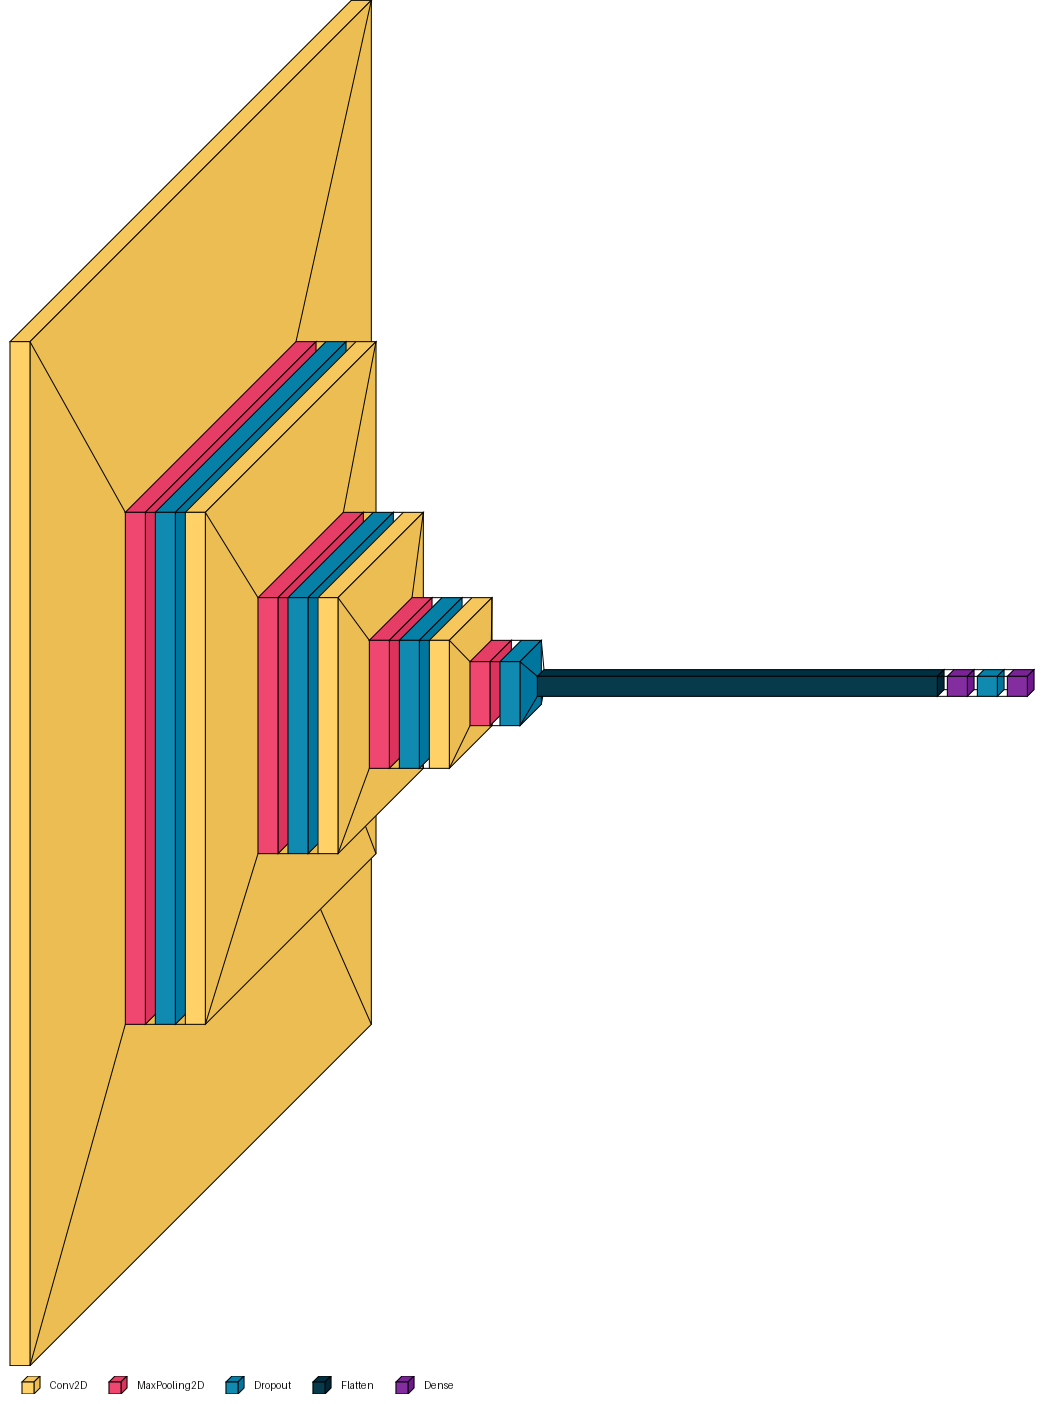

In [25]:
visualkeras.layered_view(model_with_aug, legend=True) # without custom font
from PIL import ImageFont
visualkeras.layered_view(model_with_aug, legend=True) 

In [30]:
plot_model(model_with_aug)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [32]:
start_time = time.time()

history_with_aug = model_with_aug.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_valid, y_valid),
                    epochs=45, verbose=1)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

Epoch 1/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 732ms/step - accuracy: 0.4509 - loss: 1.1985 - val_accuracy: 0.5034 - val_loss: 1.1978
Epoch 2/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 727ms/step - accuracy: 0.4641 - loss: 1.1655 - val_accuracy: 0.3878 - val_loss: 1.1978
Epoch 3/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 695ms/step - accuracy: 0.4753 - loss: 1.1338 - val_accuracy: 0.4728 - val_loss: 1.1637
Epoch 4/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 687ms/step - accuracy: 0.4926 - loss: 1.1097 - val_accuracy: 0.4898 - val_loss: 1.1225
Epoch 5/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 674ms/step - accuracy: 0.5309 - loss: 1.0764 - val_accuracy: 0.4558 - val_loss: 1.1901
Epoch 6/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 673ms/step - accuracy: 0.5319 - loss: 1.0665 - val_accuracy: 0.5102 - val_loss: 1.0943
Epoch 7/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 660ms/step - accuracy: 0.5422 - loss: 1.0367 - val_accuracy: 0.4354 - val_loss: 1.1742
Epoch 8/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 697ms/step - accuracy: 0.5794 - loss: 1.0005 - val_accu

### Plotting training and validation loss and accuracy

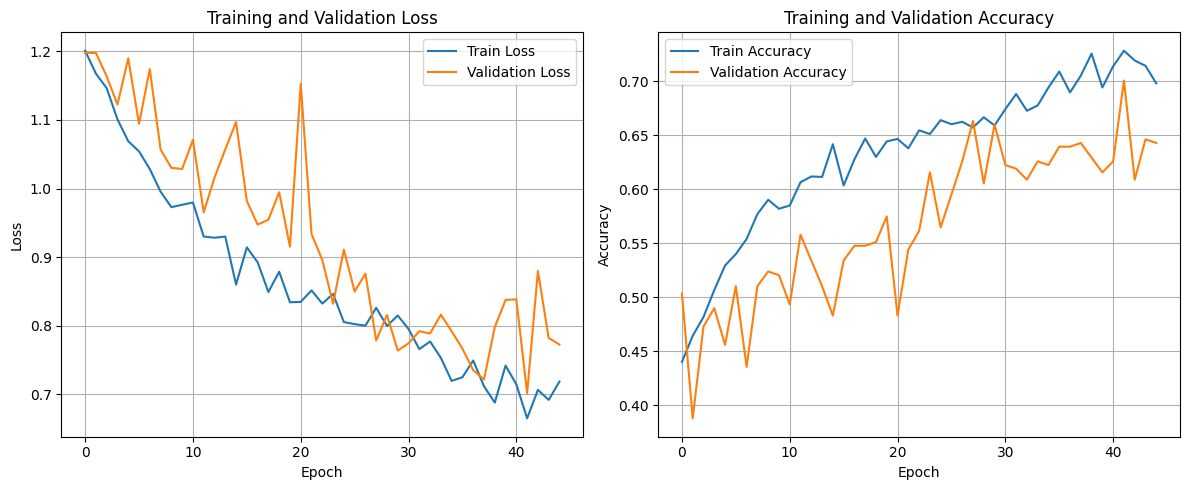

In [33]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_with_aug.history['loss'], label='Train Loss')
plt.plot(history_with_aug.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_with_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_with_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

### Saving model

In [40]:
model_with_aug.save("my_model_aug.keras")

In [43]:
model_with_aug.save_weights("my_model_aug.weights.h5")

In [44]:
model_with_aug = tf.keras.models.load_model("my_model_aug.keras")

### Confusion Matrix

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step


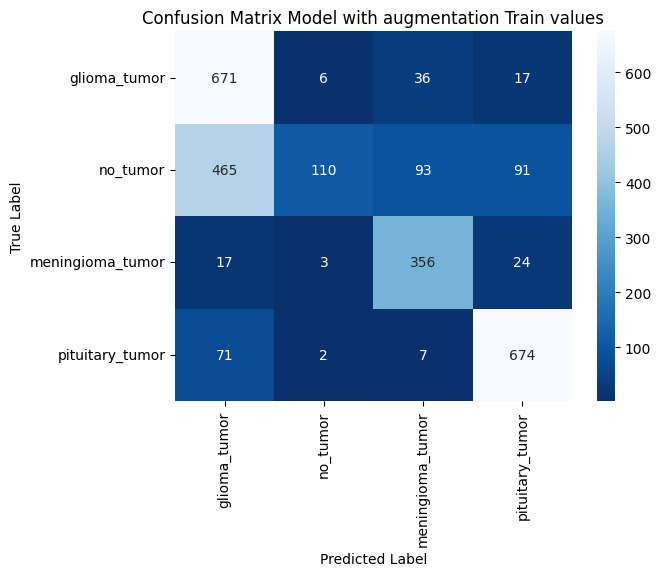

In [45]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model_with_aug.predict(X_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix Model with augmentation Train values')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


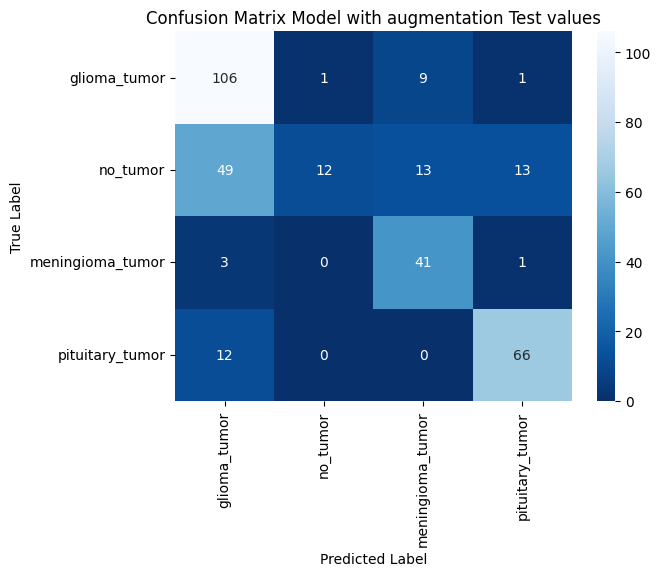

In [46]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model_with_aug.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix Model with augmentation Test values')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Classification Report

In [47]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.62      0.91      0.74       117
           1       0.92      0.14      0.24        87
           2       0.65      0.91      0.76        45
           3       0.81      0.85      0.83        78

    accuracy                           0.69       327
   macro avg       0.75      0.70      0.64       327
weighted avg       0.75      0.69      0.63       327



### Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 89.66%



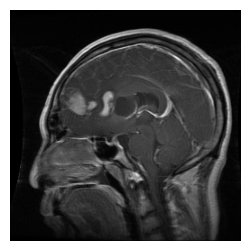

In [62]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model_with_aug.predict(random_img.reshape(1, 256, 256, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

## Model Withought Augmentation

In [63]:
model = Sequential([
    Input(shape=(256, 256, 3)),

    Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D(),
    Dropout(0.15),

    Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D(),
    Dropout(0.15),

    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(),
    Dropout(0.15),

    Conv2D(64, kernel_size=(2,2), activation='relu', padding='same'),
    MaxPooling2D(),
    Dropout(0.15),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.45),
    Dense(4, activation='softmax')
])

In [64]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,143,364 (8.18 MB)

 Trainable params: 2,143,364 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [66]:
start_time = time.time()

history = model.fit(X_train,y_train,validation_data=(X_valid, y_valid), epochs =45, verbose=1, batch_size=64)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

Epoch 1/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 856ms/step - accuracy: 0.3311 - loss: 45.5771 - val_accuracy: 0.4354 - val_loss: 1.3460
Epoch 2/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 807ms/step - accuracy: 0.4447 - loss: 1.2718 - val_accuracy: 0.4626 - val_loss: 1.2866
Epoch 3/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 834ms/step - accuracy: 0.4824 - loss: 1.1541 - val_accuracy: 0.4558 - val_loss: 1.2156
Epoch 4/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 856ms/step - accuracy: 0.5510 - loss: 1.0328 - val_accuracy: 0.4898 - val_loss: 1.1057
Epoch 5/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 786ms/step - accuracy: 0.6003 - loss: 0.9351 - val_accuracy: 0.5918 - val_loss: 0.9642
Epoch 6/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 790ms/step - accuracy: 0.6526 - loss: 0.8181 - val_accuracy: 0.6190 - val_loss: 0.9097
Epoch 7/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 786ms/step - accuracy: 0.6694 - loss: 0.7942 - val_accuracy: 0.6020 - val_loss: 0.9336
Epoch 8/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 809ms/step - accuracy: 0.6865 - loss: 0.7591 - val_acc

### Plotting training and validation loss and accuracy

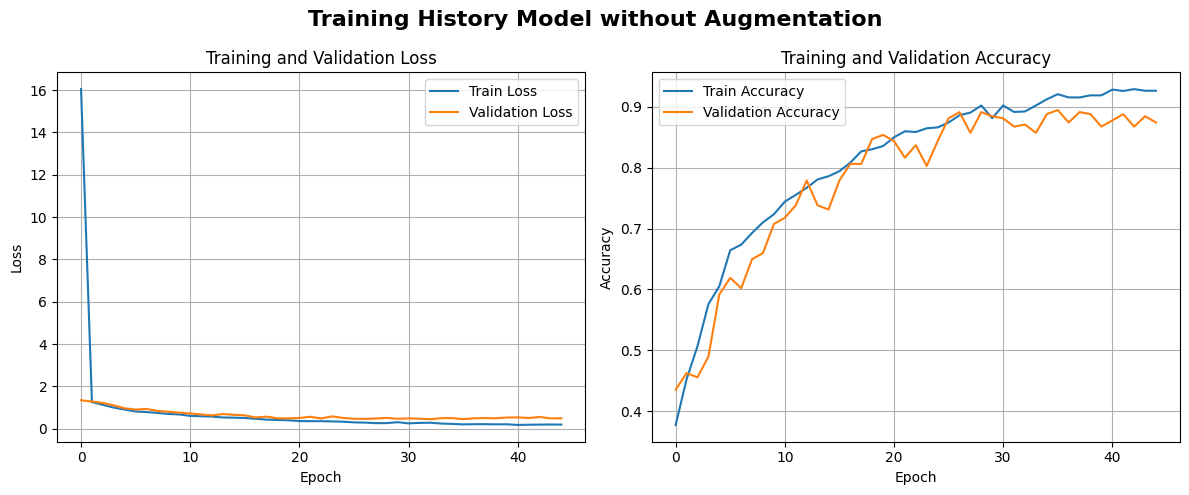

In [67]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.suptitle('Training History Model without Augmentation', fontsize=16, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

### Saving model

In [68]:
model.save("my_model_without_aug.keras")

In [69]:
model.save_weights("my_model_without_aug.weights.h5")

In [70]:
model = tf.keras.models.load_model("my_model_without_aug.keras")

### Consufion Matrix

83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step


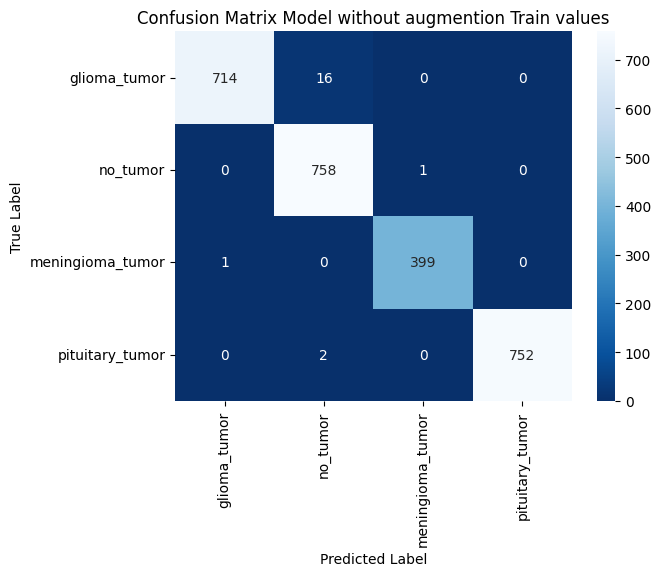

In [71]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix Model without augmention Train values')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step 


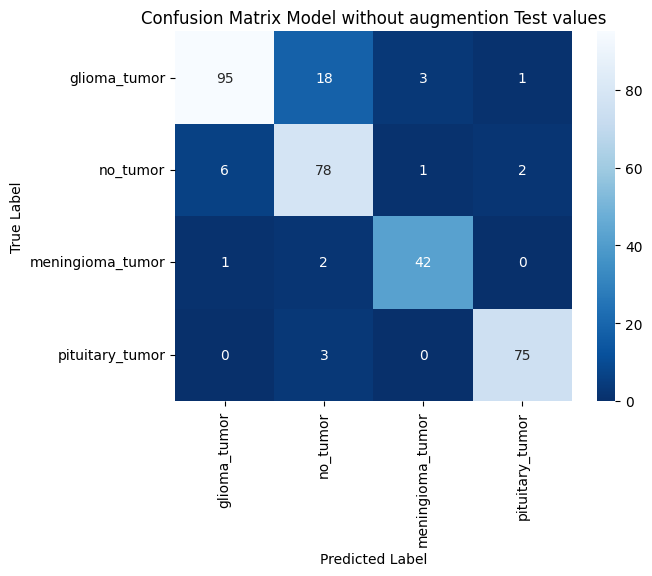

In [72]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Model without augmention Test values')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Precision: Determines the accuracy of positive predictions by indicating how many of the predicted positive instances are actually positive.

Recall: This metric measures the model's ability to correctly identify all relevant instances, indicating how many actual positive instances were correctly predicted.

F1-score: Represents the harmonic mean of precision and recall, providing a balance between the two, which is especially useful when classes are imbalanced.

Support: Indicates the number of actual occurrences of each class in the dataset, which provides context for calculating precision, recall, and F1 score.

Accuracy: Indicates the overall correctness of the model's predictions by displaying the proportion of correctly predicted instances to the total number of instances.

Macro Avg: Calculates the average precision, recall, and F1-score for all classes, treating each class equally regardless of class imbalance.

Weighted Avg: Calculates the weighted average of precision, recall, and F1-score, with each class's score weighted by its support, providing a more accurate picture of overall model performance, particularly when classes are imbalanced.

### Classification Report

In [108]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       117
           1       0.77      0.90      0.83        87
           2       0.91      0.93      0.92        45
           3       0.96      0.96      0.96        78

    accuracy                           0.89       327
   macro avg       0.89      0.90      0.90       327
weighted avg       0.89      0.89      0.89       327



In [74]:
model = tf.keras.models.load_model("my_model_without_aug.keras")

### Multiple Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


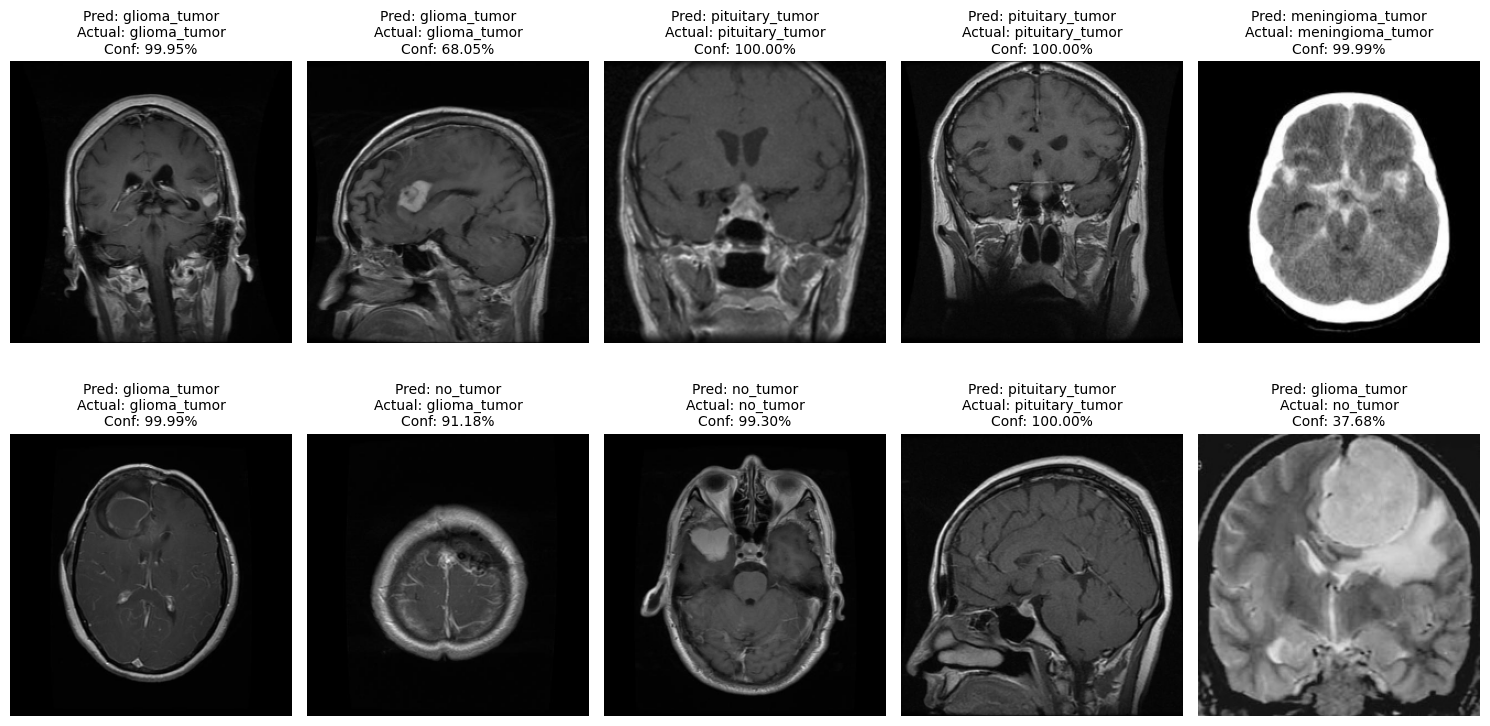


Image 1:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 99.95%

Image 2:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 68.05%

Image 3:
Predicted label: pituitary_tumor
Actual label: pituitary_tumor
Confidence: 100.00%

Image 4:
Predicted label: pituitary_tumor
Actual label: pituitary_tumor
Confidence: 100.00%

Image 5:
Predicted label: meningioma_tumor
Actual label: meningioma_tumor
Confidence: 99.99%

Image 6:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 99.99%

Image 7:
Predicted label: no_tumor
Actual label: glioma_tumor
Confidence: 91.18%

Image 8:
Predicted label: no_tumor
Actual label: no_tumor
Confidence: 99.30%

Image 9:
Predicted label: pituitary_tumor
Actual label: pituitary_tumor
Confidence: 100.00%

Image 10:
Predicted label: glioma_tumor
Actual label: no_tumor
Confidence: 37.68%


In [75]:
random_indexes = np.random.randint(0, len(X_test), 10)
random_imgs = X_test[random_indexes]
predictions = [model.predict(random_img.reshape(1, 256, 256, 3)) for random_img in random_imgs]  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_classes = [np.argmax(prediction) for prediction in predictions]  # Get the index of the class with the highest probability
predicted_labels = [labels[predicted_class] for predicted_class in predicted_classes]  # Convert class to label
confidences = [prediction[0][predicted_class] for prediction, predicted_class in zip(predictions, predicted_classes)]

actual_indexes = [y_test[random_index] for random_index in random_indexes]  # Get the one-hot encoded actual class
actual_classes = [np.argmax(actual_index) for actual_index in actual_indexes]
actual_labels = [labels[actual_class] for actual_class in actual_classes]

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(random_imgs[i])
    plt.title(f"Pred: {predicted_labels[i]}\nActual: {actual_labels[i]}\nConf: {confidences[i]*100:.2f}%",
              fontsize=10, color='black')
    plt.axis('off')
plt.tight_layout()
plt.show()

for i in range(10):
    print(f"\nImage {i+1}:")
    print(f"\033[94mPredicted label: {predicted_labels[i]}\033[0m")
    print(f"\033[92mActual label: {actual_labels[i]}\033[0m")
    print(f"\033[93mConfidence: {confidences[i]*100:.2f}%\033[0m")

## Transfer Learning

### EfficientNetB0
The EfficientNet architecture is represented by a set of ready-to-use models. The choice depends on the required accuracy, available training resources, and input image resolution. Models are labelled from B0 (simplest) to B7 (most powerful).

Graph showing the dependence of the accuracy of different models on the number of parameters

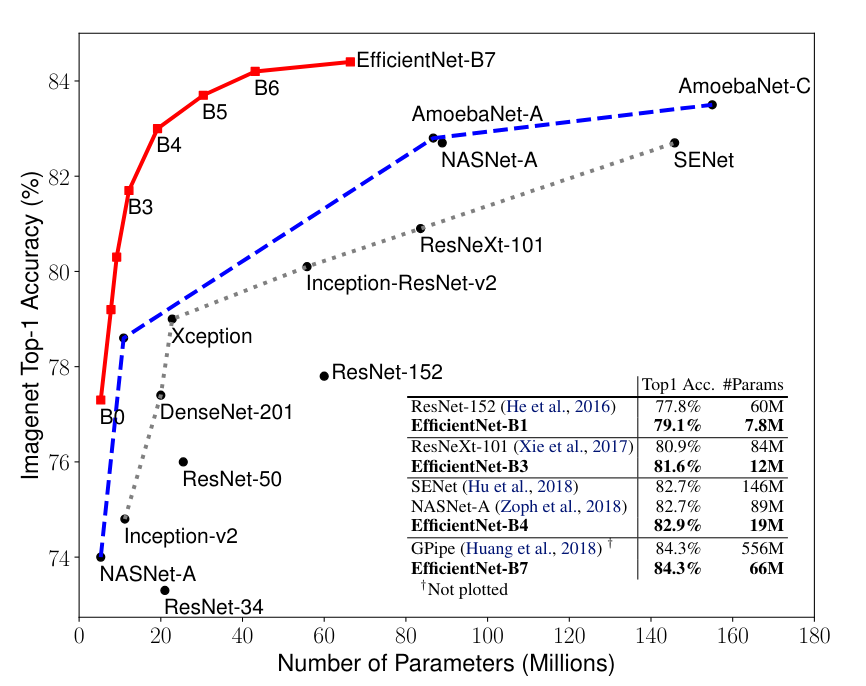

I'll use **EfficientNet-B0** architecture with the weights from **ImageNet** dataset. EfficientNet-B0 is trained on the ImageNet dataset and can classify images into 1000 object categories. The point is to re-use the weights from the pre-trained models downloading and using directly or integrating into a new model that we'll do.

The include_top parameter is set to False, so the network does not include he top layer/ output layer. We have a possibility to add our own output layer depending on our needs. (4 values)

In [76]:
base_model = EfficientNetB0(include_top = False, weights = "imagenet", input_shape = (256, 256, 3))

In [77]:
x = base_model.output

In [78]:
x = GlobalAveragePooling2D()(x)

In [79]:
x = Dropout(0.5)(x)

In [80]:
x = Dense(4, activation="softmax")(x)

In [81]:
model_eff = Model(inputs=base_model.input, outputs=x)

In [82]:
model_eff.summary()

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 256, 256, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 256, 256, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 257, 257, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 128, 128, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 128, 128, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 128, 128, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 128, 128, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 128, 128, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 128, 128, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [88]:
plot_model(model_eff)

You must install pydot (`pip install pydot`) for `plot_model` to work.


C:\Users\Alex\Desktop\My\4th_sem\machine_learning\Presentation\.venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


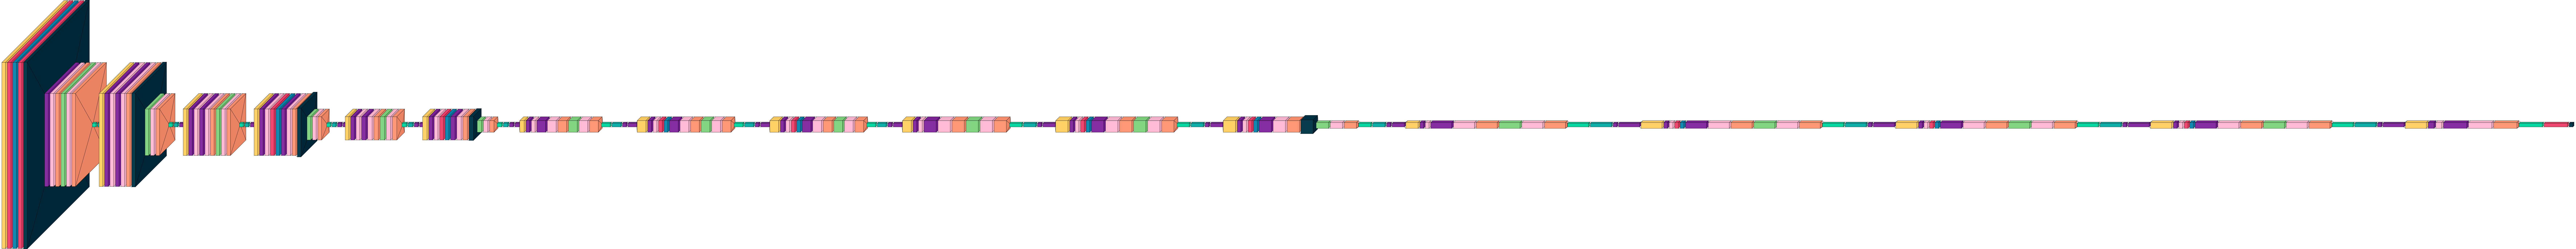

In [89]:
visualkeras.layered_view(model_eff)

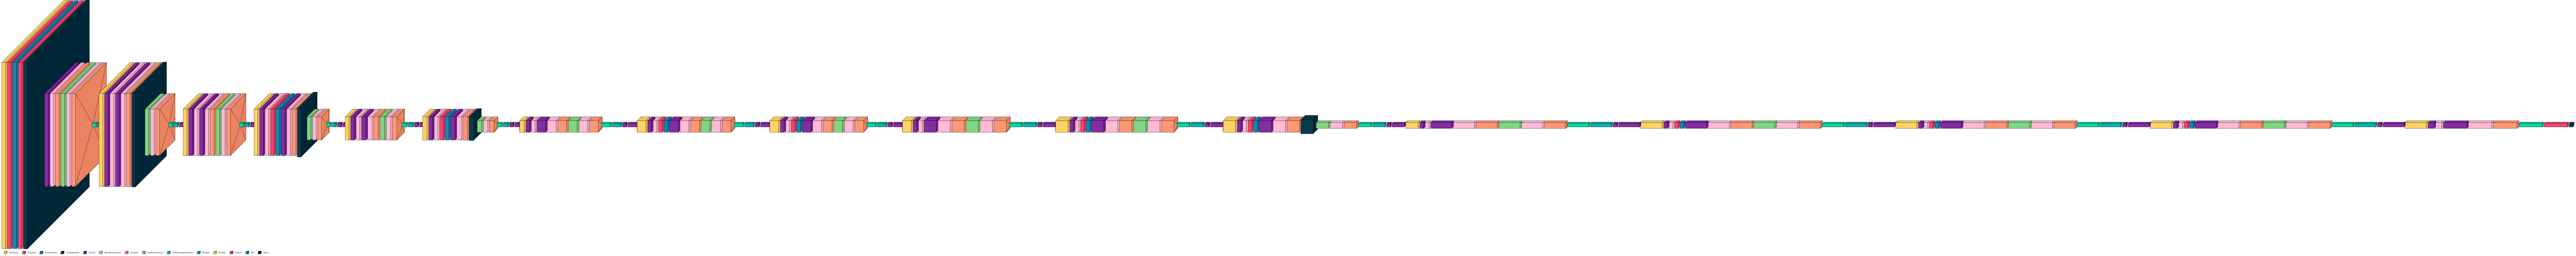

In [90]:
visualkeras.layered_view(model_eff, legend=True) # without custom font
from PIL import ImageFont
visualkeras.layered_view(model_eff, legend=True) 

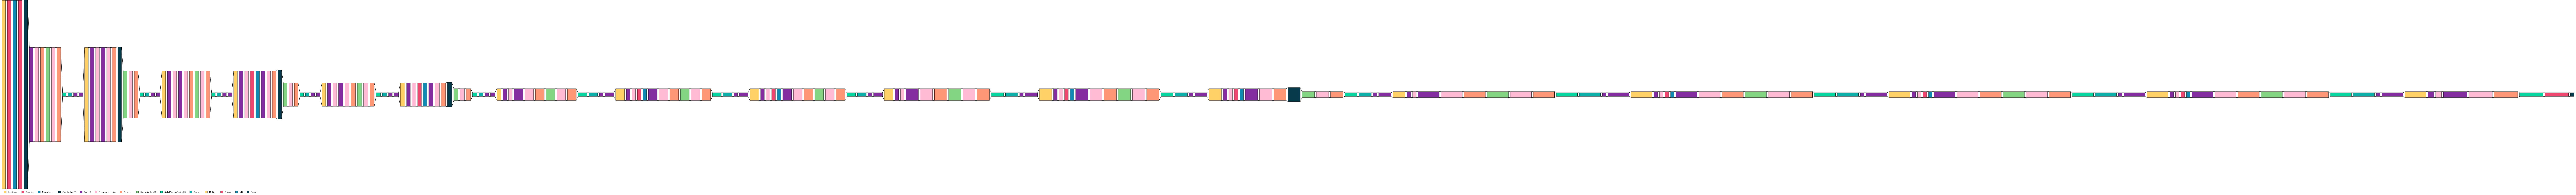

In [91]:
visualkeras.layered_view(model_eff, legend=True, draw_volume=False)

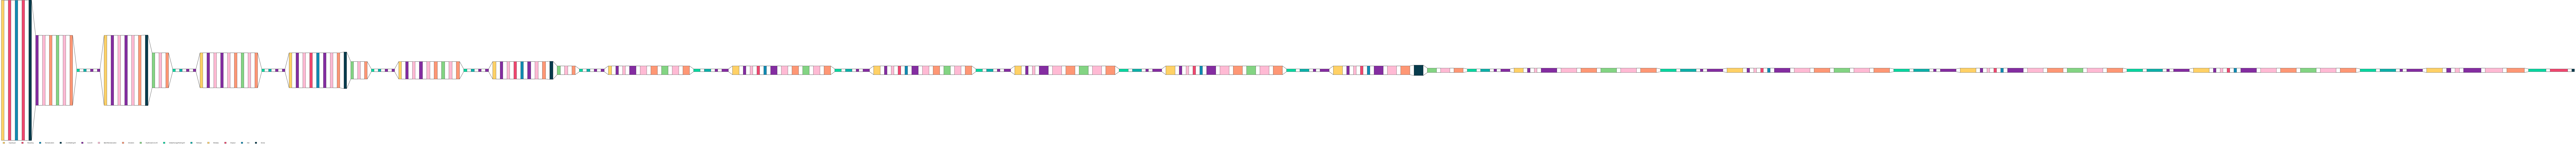

In [92]:
visualkeras.layered_view(model_eff, legend=True, draw_volume=False,spacing=30)

In [93]:
model_eff.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [94]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [95]:
history_eff = model_eff.fit(X_train, y_train, validation_split=0.1, epochs=12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7534 - loss: 0.6516  
Epoch 1: val_accuracy improved from -inf to 0.63019, saving model to effnet.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.7547 - loss: 0.6488 - val_accuracy: 0.6302 - val_loss: 1.5908 - learning_rate: 0.0010
Epoch 2/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9310 - loss: 0.2046  
Epoch 2: val_accuracy improved from 0.63019 to 0.90189, saving model to effnet.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.9311 - loss: 0.2043 - val_accuracy: 0.9019 - val_loss: 0.3133 - learning_rate: 0.0010
Epoch 3/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9689 - loss: 0.0949  
Epoch 3: val_accuracy improved from 0.90189 to 0.93962, saving model to effnet.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.9688 - loss: 0.0951 - val_accuracy: 0.9396 - val_loss: 0.1955 - learning_rate: 0.0010
Epoch 4/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9725 - los

### Plotting training and validation loss and accuracy

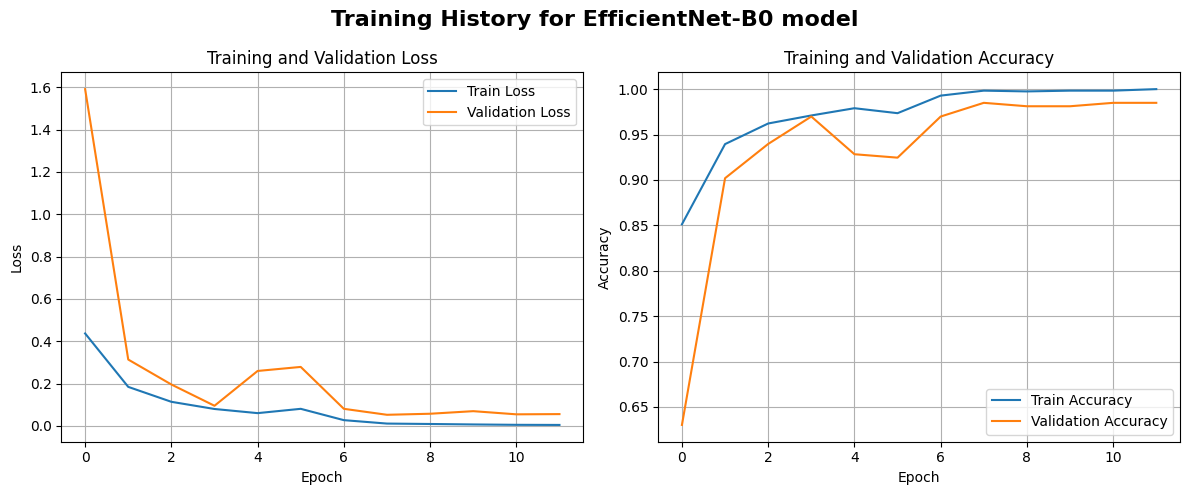

In [96]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.suptitle('Training History for EfficientNet-B0 model', fontsize=16, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(history_eff.history['loss'], label='Train Loss')
plt.plot(history_eff.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_eff.history['accuracy'], label='Train Accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

### Saving Model

In [97]:
model_eff.save("effnet.keras")

In [98]:
model_eff.save("my_model_effnet.keras")

In [109]:
model_eff = tf.keras.models.load_model("my_model_effnet.keras")

### Confusion Matrix

83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step


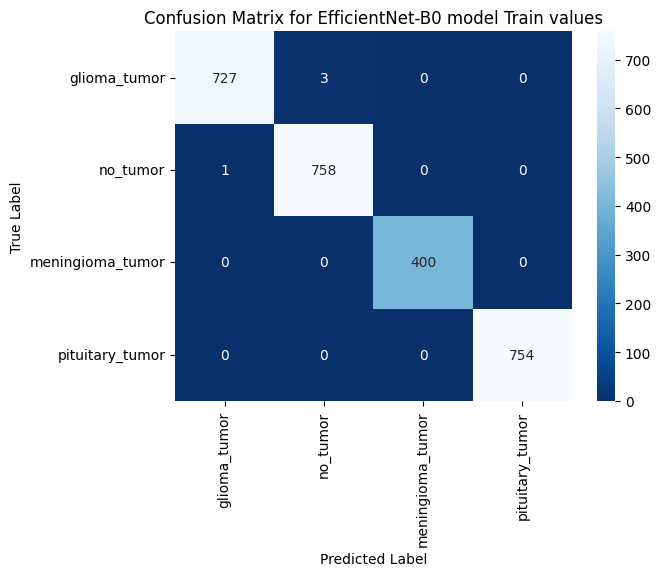

In [110]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model_eff.predict(X_train), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix for EfficientNet-B0 model Train values')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step


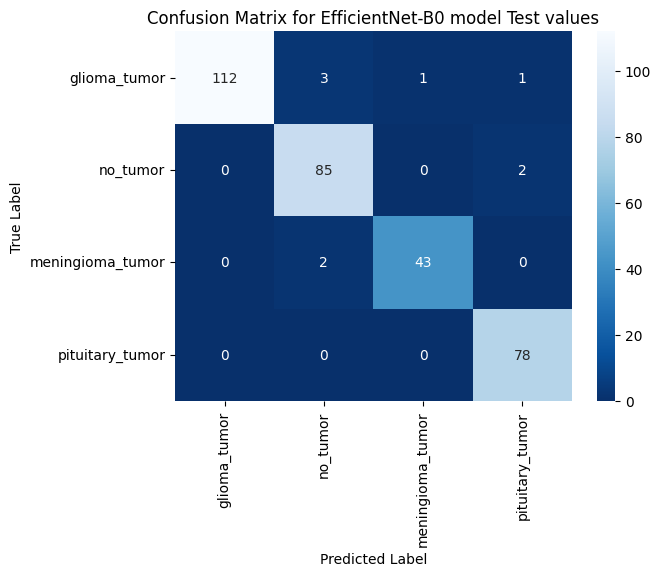

In [111]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model_eff.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for EfficientNet-B0 model Test values')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Classifiction Report

In [112]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       117
           1       0.94      0.98      0.96        87
           2       0.98      0.96      0.97        45
           3       0.96      1.00      0.98        78

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



### Multiple Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


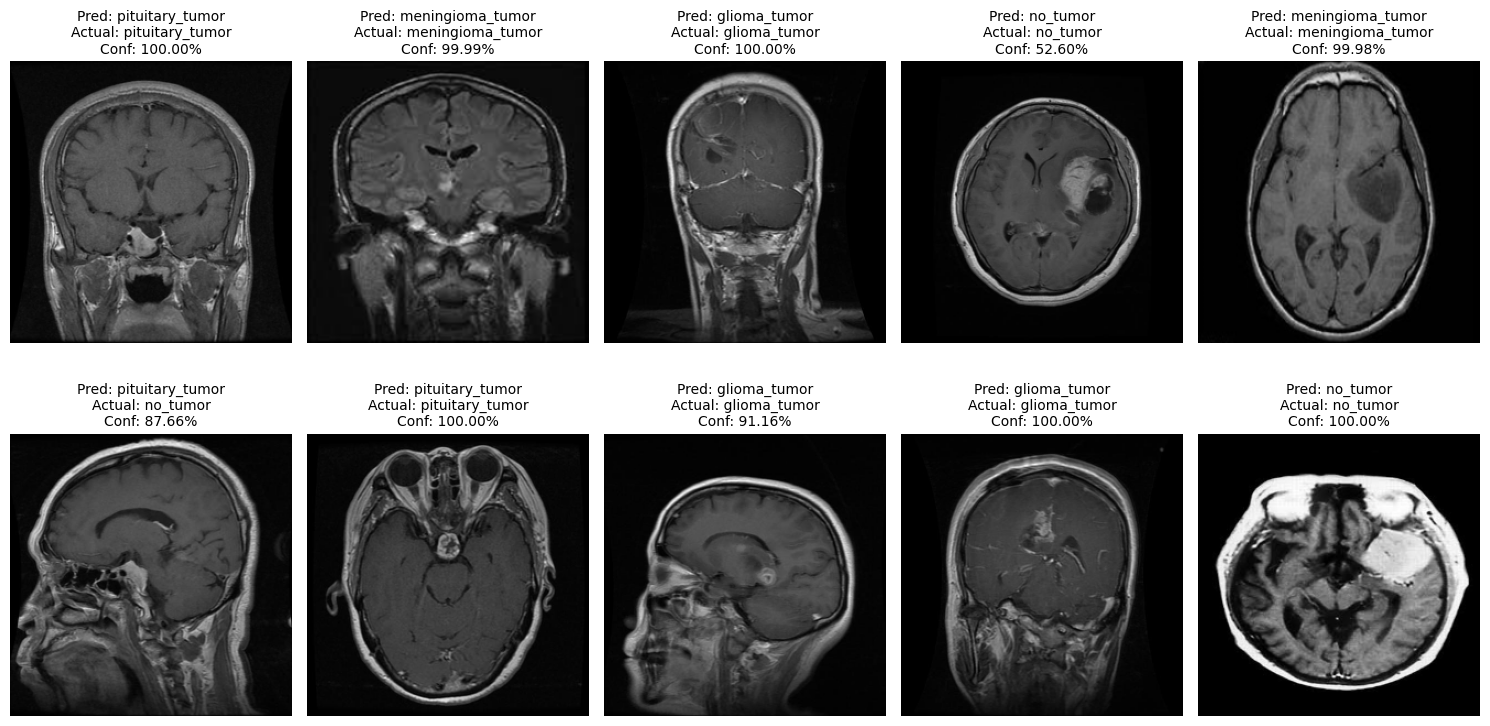


Image 1:
Predicted label: pituitary_tumor
Actual label: pituitary_tumor
Confidence: 100.00%

Image 2:
Predicted label: meningioma_tumor
Actual label: meningioma_tumor
Confidence: 99.99%

Image 3:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 100.00%

Image 4:
Predicted label: no_tumor
Actual label: no_tumor
Confidence: 52.60%

Image 5:
Predicted label: meningioma_tumor
Actual label: meningioma_tumor
Confidence: 99.98%

Image 6:
Predicted label: pituitary_tumor
Actual label: no_tumor
Confidence: 87.66%

Image 7:
Predicted label: pituitary_tumor
Actual label: pituitary_tumor
Confidence: 100.00%

Image 8:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 91.16%

Image 9:
Predicted label: glioma_tumor
Actual label: glioma_tumor
Confidence: 100.00%

Image 10:
Predicted label: no_tumor
Actual label: no_tumor
Confidence: 100.00%


In [113]:
random_indexes = np.random.randint(0, len(X_test), 10)
random_imgs = X_test[random_indexes]
predictions = [model_eff.predict(random_img.reshape(1, 256, 256, 3)) for random_img in random_imgs]  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_classes = [np.argmax(prediction) for prediction in predictions]  # Get the index of the class with the highest probability
predicted_labels = [labels[predicted_class] for predicted_class in predicted_classes]  # Convert class to label
confidences = [prediction[0][predicted_class] for prediction, predicted_class in zip(predictions, predicted_classes)]

actual_indexes = [y_test[random_index] for random_index in random_indexes]  # Get the one-hot encoded actual class
actual_classes = [np.argmax(actual_index) for actual_index in actual_indexes]
actual_labels = [labels[actual_class] for actual_class in actual_classes]

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(random_imgs[i])
    plt.title(f"Pred: {predicted_labels[i]}\nActual: {actual_labels[i]}\nConf: {confidences[i]*100:.2f}%",
              fontsize=10, color='black')
    plt.axis('off')
plt.tight_layout()
plt.show()

for i in range(10):
    print(f"\nImage {i+1}:")
    print(f"\033[94mPredicted label: {predicted_labels[i]}\033[0m")
    print(f"\033[92mActual label: {actual_labels[i]}\033[0m")
    print(f"\033[93mConfidence: {confidences[i]*100:.2f}%\033[0m")